In [1]:
using AKNS, ApproxFun, ApproxFunRational, FastGaussQuadrature, Plots, SpecialFunctions, LinearAlgebra

In [10]:
function remove_deltas!(s::AKNS.SumFun)
    i = 0
    while i < length(s.funs)
        i += 1
        if typeof(s.funs[i].space) <: AKNS.DiracSpace
            deleteat!(s.funs,i)
            i -= 1
        end
    end
    return s
end

remove_deltas! (generic function with 1 method)

## Reflection test for defocusing case

In [534]:
A = .4; γ = 1.0;
q = x -> -1im*A*x*sech(x)*exp(-1im*γ*A*log(cosh(x)))
r = x -> conj(q(x))

out = AKNSscattering(q,r,600,800)
function ref_notfun(x,out)
    s = out(x)
    return s[2,1]/s[1,1]
    #return s[1,2]/s[2,2]
end

function reft_notfun(x,out)
    s = out(x)
    return s[1,2]/s[2,2]
    #return s[1,2]/s[2,2]
end


F = FourierTransform(-1.0)
iF = FourierTransform(1.0)
## Fourier transform of potential
qhat = F*Fun(zai(q),OscLaurent(0.0,1.0),200);
rhat = iF*Fun(zai(r),OscLaurent(0.0,1.0),200);

In [535]:
x = -5:0.11:5
# FT of potential on grid
y0 = map(x -> rhat(x),x)
y1 = map(x -> qhat(x),x)
# Numerically computed reflection coefficient
y2 = map(x -> ref_notfun(x/2,out),x);
y3 = map(x -> reft_notfun(x/2,out),x);

## Compare FT of potential with reflection

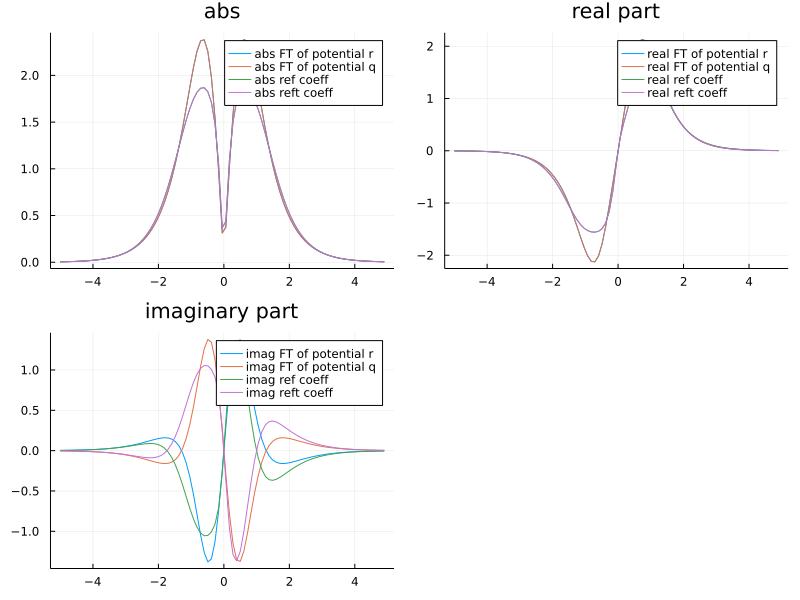

In [536]:
## ref should give a first-order approx of (in Li-Cheng's convention) q, which in my convention is r
## reft should give a first order approx of (in Li-Cheng's convention) -κp, which in my convention is q

imagplot = plot(x,imag(y0/A),label = "imag FT of potential r", title="imaginary part")
plot!(x,imag(y1/A),label = "imag FT of potential q")
plot!(x,imag(y2/A),label = "imag ref coeff")
plot!(x,imag(y3/A),label = "imag reft coeff")

realplot = plot(x,real(y0/A),label = "real FT of potential r", title="real part")
plot!(x,real(y1/A),label = "real FT of potential q")
plot!(x,real(y2/A),label = "real ref coeff")
plot!(x,real(y3/A),label = "real reft coeff")

absplot = plot(x,abs.(y0/A),label = "abs FT of potential r", title="abs")
plot!(x,abs.(y1/A),label = "abs FT of potential q")
plot!(x,abs.(y2/A),label = "abs ref coeff")
plot!(x,abs.(y3/A),label = "abs reft coeff")

plot(absplot, realplot, imagplot, size=(800,600))


In [537]:
#iF = FourierTransform(1.0) # negative in fourier exponent

#### THIS IS THE KERNEL FUNCTION ####
ρ = 1/(2*pi)*(F*Fun(zai(x -> ref_notfun(x/2,out)),OscLaurent(0.0,0.5),600)) |> AKNS.SumFun |> remove_deltas!;
ρt = 1/(2*pi)*(iF*Fun(zai(x -> reft_notfun(x/2,out)),OscLaurent(0.0,0.5),600)) |> AKNS.SumFun |> remove_deltas!;

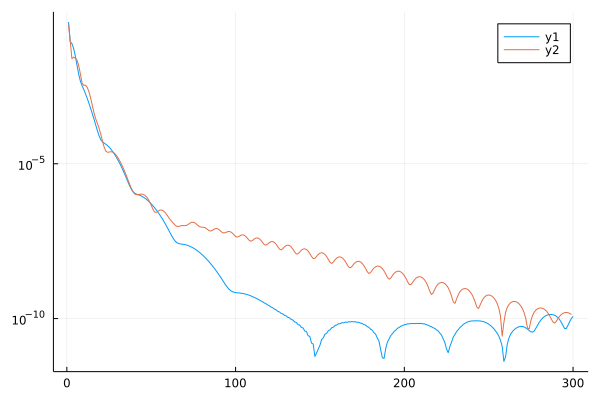

In [538]:
plot(abs.(coefficients(ρ.funs[1])),yaxis=:log)
plot!(abs.(coefficients(ρ.funs[2])),yaxis=:log)

In [542]:
quad = gausslegendre(200)

## I checked that the Gauss Legendre weigts given here are the same as the one in Mathematica 
function potential_fredholm_new(x)
    M = abs(2x) + 40
    xsp = M*(quad[1] .+ 1)/2
    xsm = xsp .- M
    ω = sqrt.(quad[2]*M/2)
    W = Diagonal(ω.^2)

    f = (X,Y) -> ρt(x-X+Y+5e-16)
    Bx = f.(xsm,xsp')*W

    f = (X,Y) -> ρ(x+X-Y+5e-16)
    Ax = f.(xsp,xsm')*W
    Avecm = W*map(z -> ρ(x-z+5e-16),xsm)
    Avecp = map(z -> ρ(x+z+5e-16),xsp)

    ρ(x) + transpose(Avecm)*((I - Bx*Ax)\(Bx*Avecp))
end

potential_fredholm_new (generic function with 1 method)

In [543]:
potential_fredholm_new(-1.0) - r(-1.0)

-1.0377424190799456e-8 - 2.027920886771284e-9im

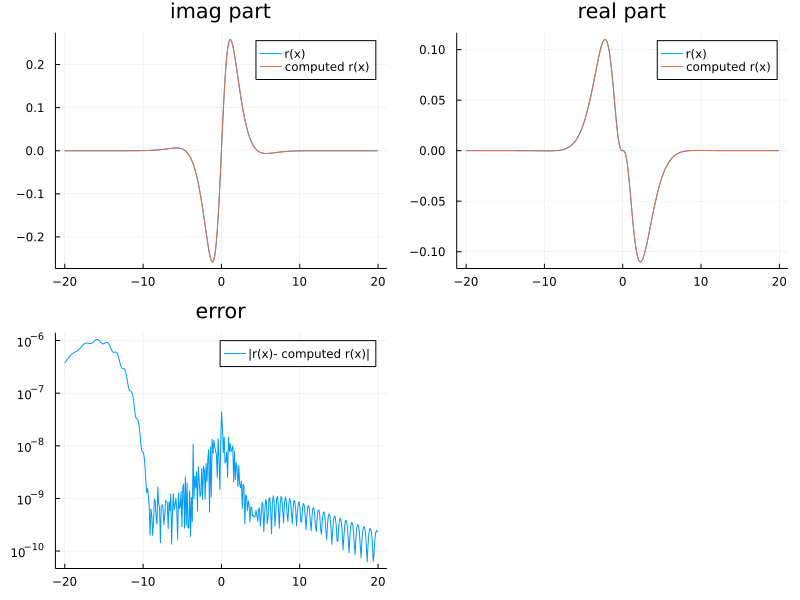

In [544]:
x = -20:0.11:20
# Potential on grid
y1 = map(x -> r(x),x);
# Computed r
y2 = map(potential_fredholm_new,x);
# FT of computed reflection coefficient

realplot = plot(x,real(y1), label = "r(x)", title = "real part")
plot!(x,real(y2), label = "computed r(x)")

imagplot = plot(x,imag(y1), label = "r(x)", title = "imag part")
plot!(x,imag(y2), label = "computed r(x)")

errplot = plot(x,abs.(y1-y2), label = "|r(x)- computed r(x)|", title = "error", yaxis = :log)

plot(imagplot, realplot, errplot, size=(800,600))


